In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

%matplotlib inline

In [2]:
#Load Ripple Dataset
from os import path
import pickle

with open('LFP_Segs.pkl', 'rb') as f: 
    data = pickle.load(f)
    X = data[0]
    y = data[1]

In [3]:
#Normalise ripple seg array
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

<Figure size 1440x1440 with 0 Axes>

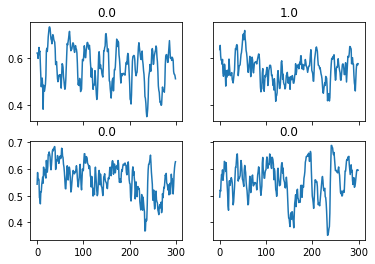

In [4]:
#Plot sample segments
rows, cols = 2, 2
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(rows, cols,
                       sharex='col', 
                       sharey='row')
for row in range(2):
    for col in range(2):
        rind = np.random.randint(0,len(X))
        ax[row,col].plot(X[rind])
        ax[row,col].set_title('{}'.format(y[rind]))

In [5]:
#Split into training and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
from sklearn.metrics import classification_report
def score_model(model,X_test,y_test):
    '''
    Get predictions and a classification report
    '''
    #Test model accuracy
    test_loss, test_acc = model.evaluate(X_test,y_test)

    predictions = model.predict(X_test)
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0

    print(classification_report(y_test, predictions))
    
    return predictions

In [7]:
# Reshape X_train & X_test into format for model
n_features = 1
n_steps = len(X_train[0])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [8]:
np.shape(X_train)

(4013, 300, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#    ---    LSTM Model   ---

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=20)

#Save best model
mc = ModelCheckpoint('best_model_relu.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

# --- Model architecture
model2 = Sequential()
#LSTM Layers
model2.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(n_steps, n_features)))
model2.add(LSTM(100, return_sequences=True, activation='relu'))
model2.add(LSTM(100, activation='relu'))
#Activation Layer
model2.add(Dense(1, activation='sigmoid'))

#Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit model
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=1, callbacks=[es,mc])

Train on 4013 samples, validate on 1721 samples
Epoch 1/200
4013/4013 [==============================] - 71s 18ms/sample - loss: 0.6935 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.4858
Epoch 2/200
4013/4013 [==============================] - 69s 17ms/sample - loss: 0.6930 - accuracy: 0.5078 - val_loss: 0.6925 - val_accuracy: 0.5200
Epoch 3/200
4013/4013 [==============================] - 71s 18ms/sample - loss: 0.6922 - accuracy: 0.5235 - val_loss: 0.6855 - val_accuracy: 0.5805
Epoch 4/200
4013/4013 [==============================] - 68s 17ms/sample - loss: 0.6966 - accuracy: 0.5275 - val_loss: 0.6917 - val_accuracy: 0.5102
Epoch 5/200
4013/4013 [==============================] - 69s 17ms/sample - loss: 17.1916 - accuracy: 0.5333 - val_loss: 0.6915 - val_accuracy: 0.5660
Epoch 6/200
4013/4013 [==============================] - 72s 18ms/sample - loss: 0.6913 - accuracy: 0.5208 - val_loss: 59528804923722055680.0000 - val_accuracy: 0.4881
Epoch 7/200
4013/4013 [===============

In [16]:
predictions2 = score_model(model2,X_test,y_test)

1721/1721 [==============================] - 9s 5ms/sample - loss: 0.6954 - accuracy: 0.4881
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       881
         1.0       0.49      1.00      0.66       840

    accuracy                           0.49      1721
   macro avg       0.24      0.50      0.33      1721
weighted avg       0.24      0.49      0.32      1721



C:\Users\em13905\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from tensorflow.keras.models import load_model

# load the saved model
saved_model = load_model('best_model_v2.h5')

#Test Model Accuracy
saved_predictions = score_model(saved_model,X_test,y_test)

1721/1721 [==============================] - 9s 5ms/sample - loss: 0.6373 - accuracy: 0.6601
              precision    recall  f1-score   support

         0.0       0.70      0.59      0.64       881
         1.0       0.63      0.73      0.68       840

    accuracy                           0.66      1721
   macro avg       0.66      0.66      0.66      1721
weighted avg       0.67      0.66      0.66      1721



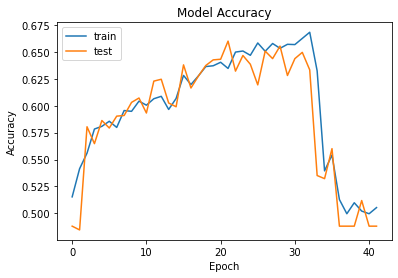

In [19]:
# Plot accuracy over epochs
plt.plot(model2.history.history['accuracy'],label='train')
plt.plot(model2.history.history['val_accuracy'],label='test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

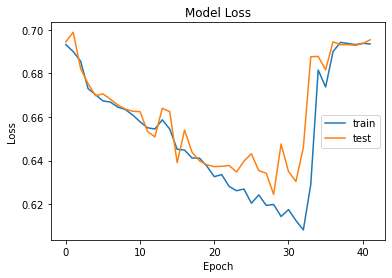

In [22]:
# Plot loss over epochs
plt.plot(model2.history.history['loss'],label='train')
plt.plot(model2.history.history['val_loss'],label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')

In [88]:
from tensorflow.keras.layers import Conv1D, Dropout, BatchNormalization, TimeDistributed, ReLU, Bidirectional
from tensorflow.keras import optimizers

#    ---    RippleNet Inspired Architecture    ---

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=10)

#Save best model
mc = ModelCheckpoint('best_RN_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#Clip Optimizer to avoid NaN values
optimizer = optimizers.Adam(learning_rate=0.005)

# --- Model architecture
modelRN = Sequential()
#1st Conv Layer
modelRN.add(Conv1D(filters=20,kernel_size=11,padding='same',use_bias=False,input_shape=(n_steps, n_features)))
modelRN.add(Dropout(rate=0.2))
#2nd Conv Layer
modelRN.add(Conv1D(filters=10,kernel_size=11,padding='same'))
modelRN.add(BatchNormalization())
modelRN.add(Dropout(rate=0.2))
#1st LSTM Layer
modelRN.add(Bidirectional(LSTM(units=20, return_sequences=True)))
modelRN.add(BatchNormalization())
modelRN.add(Dropout(rate=0.2))
#2nd LSTM Layer
modelRN.add(Bidirectional(LSTM(units=20, return_sequences=True)))
modelRN.add(Dropout(rate=0.2))
modelRN.add(BatchNormalization())
modelRN.add(Dropout(rate=0.2))
#Activation Layer
modelRN.add(Dense(1, activation='sigmoid'))

#Compile model
modelRN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#Fit model
modelRN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=20, verbose=1, callbacks=[es,mc])

Train on 4013 samples, validate on 1721 samples
Epoch 1/50
4013/4013 [==============================] - 50s 12ms/sample - loss: 0.7154 - accuracy: 0.5139 - val_loss: 0.6920 - val_accuracy: 0.5144
Epoch 2/50
4013/4013 [==============================] - 43s 11ms/sample - loss: 0.6914 - accuracy: 0.5282 - val_loss: 0.6918 - val_accuracy: 0.5218
Epoch 3/50
4013/4013 [==============================] - 42s 10ms/sample - loss: 0.6883 - accuracy: 0.5427 - val_loss: 0.6932 - val_accuracy: 0.4939
Epoch 4/50
4013/4013 [==============================] - 42s 10ms/sample - loss: 0.6867 - accuracy: 0.5499 - val_loss: 0.7013 - val_accuracy: 0.5124
Epoch 5/50
4013/4013 [==============================] - 42s 10ms/sample - loss: 0.6800 - accuracy: 0.5693 - val_loss: 0.6985 - val_accuracy: 0.5202
Epoch 6/50
4013/4013 [==============================] - 42s 11ms/sample - loss: 0.6857 - accuracy: 0.5537 - val_loss: 0.6895 - val_accuracy: 0.5357
Epoch 7/50
4013/4013 [==============================] - 42s 11ms